# Evaluation pipeline

Note:

- We are exploring how LLMs could assist humans to be more creative. To do so, we are exploring how LLMs are creative compared to humans, by evaluating their creativity along specific dimensions on the AUT. Do humans and LLMs have common patterns of creativity ? Is there some differences ? How could they complement each other ?

**GOAL:**

Design a full pipeline for multi-dimensional evaluation of the outputs of a given combination of prompt & LLM for the AUT. 

Inputs:

- outputs of a model with originality and elaboration for the 4 objects for
    - a given LLM (GPTs, open-source models)
    - a given prompt (simple, Few shot prompting, Chain of Thought prompting, ...., RAG)

Ouput:

- graphs, radar charts (1 per object)



<!-- HTML table for benchmark evaluation -->
<table style="border-collapse: collapse; width: 100%; border: 1px solid black;">
    <thead>
        <tr style="background-color: #f2f2f2;">
            <th style="padding: 8px; border: 1px solid black; text-align: left;">LLM</th>
            <th style="padding: 8px; border: 1px solid black; text-align: left;">Prompt</th>
            <th style="padding: 8px; border: 1px solid black; text-align: left;">Mean Originality</th>
            <th style="padding: 8px; border: 1px solid black; text-align: left;">Std Originality</th>
            <th style="padding: 8px; border: 1px solid black; text-align: left;">Elaboration</th>
            <th style="padding: 8px; border: 1px solid black; text-align: left;">Flexibility</th>
        </tr>
    </thead>
    <tbody>
        <!-- Row 1 -->
        <tr>
            <td style="padding: 8px; border: 1px solid black;">GPT-3.5</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
        </tr>
        <!-- Row 2 -->
        <tr>
            <td style="padding: 8px; border: 1px solid black;">GPT-3.5</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
        </tr>
        <!-- Row 3 -->
        <tr>
            <td style="padding: 8px; border: 1px solid black;">GPT-4</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
        </tr>
        <!-- Row 4 -->
        <tr>
            <td style="padding: 8px; border: 1px solid black;">GPT-4</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
        </tr>
        <!-- Row 5 -->
        <tr>
            <td style="padding: 8px; border: 1px solid black;">Mistral</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
        </tr>


In [36]:
import re
import string
import numpy as np
from math import pi
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt

from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections import register_projection
from matplotlib.projections.polar import PolarAxes
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D

# Download NLTK resources
import nltk
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')  
nltk.download('omw-1.4')  
nltk.download('averaged_perceptron_tagger')

# Define stop words, lemmatizer
stop_words = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()

# import gensim
from pprint import pprint# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel# spaCy for preprocessing
import spacy# Plotting tools
import pyLDAvis
import pyLDAvis.gensim
from gensim.models import LdaModel

import warnings
warnings.filterwarnings('ignore')

# import other python files
from utils_benchmark import *
from utils import *
from elaboration import *
from similarity import *
from flexibility import *
from process_humans_data import *

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Maxime\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Maxime\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Maxime\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Maxime\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Maxime\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [37]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data

- Humans
    - Data has already been processed with `run_LDA_on_humans_data` and `process_humans_data.py`

In [4]:
# Humans
humans = pd.read_csv('./data_processed/humans_data_processed.csv')
print('Humans:', len(humans))
objects = list(humans['prompt'].value_counts().head(4).index)
humans.head()

Humans: 10985


,prompt,response,originality,elaboration,dissimilarity,elaboration_SW,flexibility
0,brick,strength tester (punching),2.7,5,0.294817,5,0.00000
1,brick,art,2.1,1,0.330149,1,0.00000
2,brick,pencil holder,2.1,2,0.246490,2,1.50901
3,brick,writing utensil,2.1,2,0.232353,2,0.00000
4,brick,earrings,2.2,1,0.275411,1,0.00000


Below is the code to process humans data

Rerun only if changing 2 parameters:
- Number of topics of the LDA: `num_topics`
- Number of words for the coeff of the flexibility score: `num_words`

In [6]:
num_topics = 5
num_words = 5

dict_kw_coeff = run_LDA_on_humans_data(humans, num_topics, num_words, print_keywords = False, objects = objects)
pprint(dict_kw_coeff[:num_topics]) # print coeff for the first object

#humans_processed = compute_all_metrics(humans, objects, dict_kw_coeff, num_topics)
# save humans data processed
#humans_processed.to_csv('./....csv', index = False)

Number of documents in corpus for object "brick": 4056
Number of documents in corpus for object "box": 2703
Number of documents in corpus for object "knife": 2178
Number of documents in corpus for object "rope": 2048
Frequency of topics: [462, 414, 534, 1248, 727]
Frequency of topics: [521, 126, 179, 547, 200]
Frequency of topics: [204, 284, 220, 529, 517]
Frequency of topics: [384, 159, 54, 234, 402]
[{'coeff': 0.8635155096011817,
  'keywords': ['brick', 'used', 'paint', 'play', 'decoration'],
  'object': 'brick',
  'topic': 0},
 {'coeff': 0.8776957163958641,
  'keywords': ['put', 'keep', 'garden', 'window', 'holder'],
  'object': 'brick',
  'topic': 1},
 {'coeff': 0.842245199409158,
  'keywords': ['build', 'car', 'house', 'someone', 'building'],
  'object': 'brick',
  'topic': 2},
 {'coeff': 0.6313146233382569,
  'keywords': ['use', 'something', 'hold', 'hole', 'thing'],
  'object': 'brick',
  'topic': 3},
 {'coeff': 0.7852289512555392,
  'keywords': ['make', 'weight', 'throw', 'coul

- LLMs
    - Data collected from OpenAI API or local server for open-source models

In [7]:
# LLMs

# GPT-3.5
gpt_35 = pd.read_csv('./data_to_process/ocsai_eval_merged_gpt_35_100.csv')

# GPT-4
gpt_4 = pd.read_csv('./data_to_process/ocsai_eval_merged_gpt_4_100.csv')

# Mistral
mistral = pd.read_csv('./data_to_process/mistral_merged_120.csv')

# Vicuna
vicuna = pd.read_csv('./data_to_process/vicuna_merged_94.csv')

# print length of each dataset
print('GPT-3.5:', len(gpt_35))
print('GPT-4:', len(gpt_4))
print('Mistral:', len(mistral))
print('Vicuna:', len(vicuna))

display(gpt_35.head(1), gpt_4.head(1), mistral.head(1), vicuna.head(1))

GPT-3.5: 323
GPT-4: 360
Mistral: 120
Vicuna: 94


,prompt,response,originality,elaboration
0,box,Use it as a makeshift stool for reaching high ...,1.7,10.0


,prompt,response,originality,elaboration
0,box,Transform it into a mini garden for succulents.,3.0,8.0


,prompt,response,originality,elaboration
0,brick,Use it as a doorstop,1.0,5


,prompt,response,originality,elaboration
0,brick,Use it as a doorstop,1.0,5.0


## Compute evaluation metrics

- for elaboration: done with OCSAI, put elab_method = 'whitespace'
- for elaboration without stop words: run `elaboration_SW`
- for similarity: run `compute_sentences_sim_per_object`
- for flexibility: run `compute_flexibility_score`

In [153]:
# compute metrics
df_process = gpt_4.copy()

# Elaboration without stop words
print("Compute elaboration without SW...")
df_process = elaboration_SW(df_process)

# Similarity
print("Compute similarity...")
embeddings_model_name = "distilbert-base-uncased"
test = compute_sentences_sim_per_object(df_process, embeddings_model_name)

# Flexibility
print("Compute flexibility...")
df_process = compute_flexibility_score(df_process, dict_kw_coeff, num_topics, objects)

Compute elaboration without SW...
Compute similarity...


100%|██████████| 89/89 [00:00<00:00, 132514.40it/s]

Compute flexibility...


In [155]:
print(f"Length of dataframe processed: {len(df_process)}")

# save processed data
df_process.to_csv(f'./data_processed/gpt4_{len(df_process)}_prompt_1.csv', index = False)

df_process.head()

Length of dataframe processed: 360


,prompt,response,originality,elaboration,elaboration_SW,dissimilarity,flexibility
91,brick,Use it as a doorstop to keep doors open.,1.0,9.0,6,0.185258,0.877696
92,brick,Paint it and use it as a bookend.,2.0,8.0,4,0.208371,0.631315
93,brick,Stack several to create a rustic outdoor stool.,1.7,8.0,7,0.194646,0.000000
94,brick,Use as a base for a makeshift outdoor grill.,2.0,9.0,6,0.194067,0.785229
95,brick,Use it to press flowers and leaves for crafts.,3.0,9.0,6,0.210208,0.785229


# Visualization

In [5]:
# import last processed data
# GPT-3.5
gpt_35_processed = pd.read_csv('./data_processed/gpt35_352_prompt_2.csv')

# GPT-4
gpt_4_processed = pd.read_csv('./data_processed/gpt4_361_prompt_2.csv')

# Mistral
mistral_processed = pd.read_csv('./data_processed/mistral_120.csv')

# Vicuna
vicuna_processed = pd.read_csv('./data_processed/vicuna_94.csv')

# print length of each dataset
print('GPT-3.5:', len(gpt_35_processed))
print('GPT-4:', len(gpt_4_processed))
print('Mistral:', len(mistral_processed))
print('Vicuna:', len(vicuna_processed))

display(gpt_35_processed.head(1), gpt_4_processed.head(1), mistral_processed.head(1), vicuna_processed.head(1))

GPT-3.5: 352
GPT-4: 361
Mistral: 120
Vicuna: 94


,prompt,response,originality,elaboration,elaboration_SW,dissimilarity,flexibility
0,brick,Paint it and turn it into a bookend,2.0,8.0,3,0.171793,0.0


,prompt,response,originality,elaboration,elaboration_SW,dissimilarity,flexibility
0,brick,Use as a paperweight for outdoor projects,1.7,7.0,4,0.208741,0.785229


,prompt,response,originality,elaboration,elaboration_SW,dissimilarity,flexibility
0,brick,Use it as a doorstop,1.0,5,2,0.203654,0.0


,prompt,response,originality,elaboration,elaboration_SW,dissimilarity,flexibility
0,brick,Use it as a doorstop,1.0,5.0,2,0.155539,0.0


## Overall radar chart

Question: Which model performs better and along which dimensions ?

In [6]:
# normalize 
combined_data = pd.concat([
    humans.assign(dataset='Humans'),
    gpt_35_processed.assign(dataset='GPT-3.5'),
    gpt_4_processed.assign(dataset='GPT-4'),
    mistral_processed.assign(dataset='Mistral'),
    vicuna_processed.assign(dataset='Vicuna')
])

combined_data_norm = normalization_1(combined_data, check_norm = False)

In [10]:
combined_data_norm.head()

,prompt,response,originality,elaboration,dissimilarity,elaboration_SW,flexibility,dataset
0,brick,strength tester (punching),0.425,0.081633,0.528945,0.217391,0.000000,Humans
1,brick,art,0.275,0.000000,0.612127,0.043478,0.000000,Humans
2,brick,pencil holder,0.275,0.020408,0.415168,0.086957,0.313009,Humans
3,brick,writing utensil,0.275,0.020408,0.381885,0.086957,0.000000,Humans
4,brick,earrings,0.300,0.000000,0.483258,0.043478,0.000000,Humans


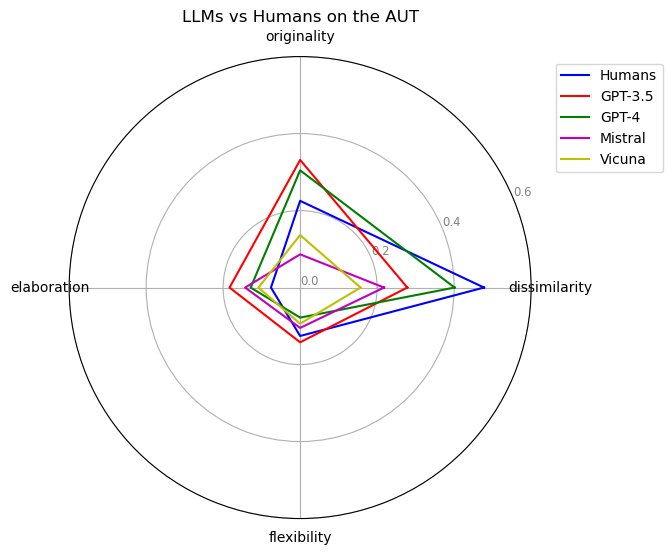

In [7]:
#features = ['prompt', 'originality', 'elaboration', 'elaboration_SW', 'cosine_dist']
#features = ['prompt', 'dissimilarity', 'originality', 'elaboration', 'elaboration_SW']
features = ['prompt', 'dissimilarity', 'originality', 'elaboration', 'flexibility']

humans_norm = combined_data_norm[combined_data_norm['dataset'] == 'Humans']
gpt_35_norm = combined_data_norm[combined_data_norm['dataset'] == 'GPT-3.5']
gpt_4_norm = combined_data_norm[combined_data_norm['dataset'] == 'GPT-4']
mistral_norm = combined_data_norm[combined_data_norm['dataset'] == 'Mistral']
vicuna_norm = combined_data_norm[combined_data_norm['dataset'] == 'Vicuna']

# List of dataframes and corresponding titles
dataframes = [humans_norm[features], gpt_35_norm[features], gpt_4_norm[features], mistral_norm[features], vicuna_norm[features]]
titles = ['Humans', 'GPT-3.5', 'GPT-4', 'Mistral', 'Vicuna']
colors = ['b', 'r', 'g', 'm', 'y']

# Plot radar chart for multiple dataframes
plot_radar_chart(dataframes, titles, colors, avg_per_object = True)

# Radar charts per object

Question: Given an object, how are humans and LLMs performing ? Is it different and how ? (along which dimensions ?)

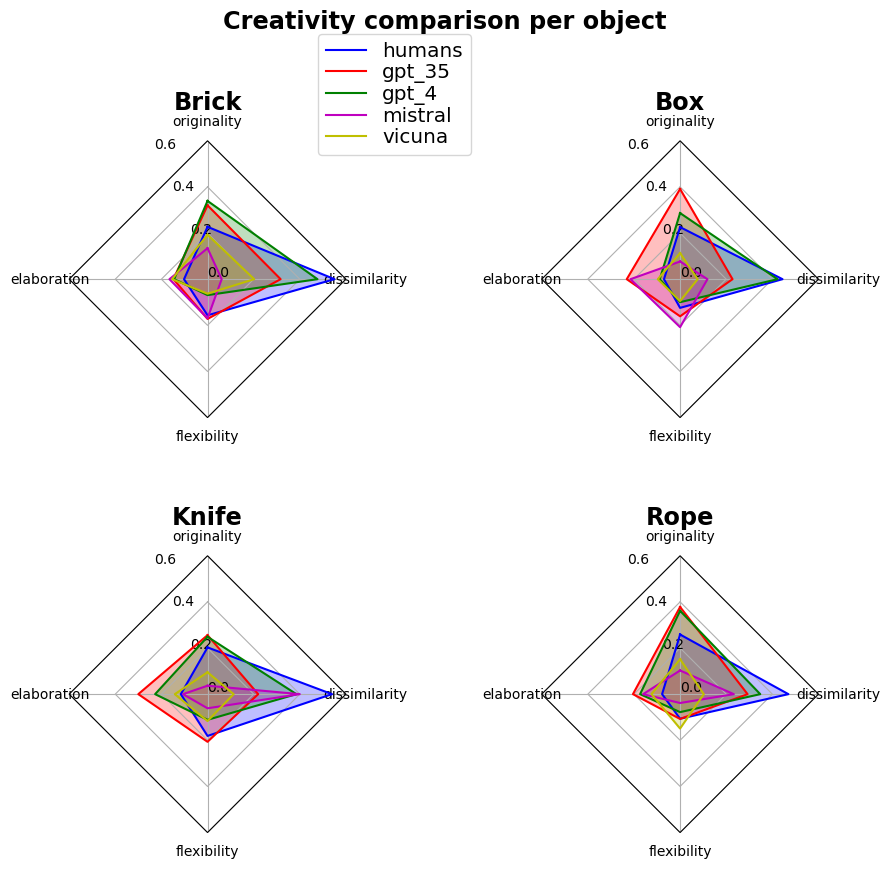

In [38]:
### PARAMETERS ###
data_dict = {"humans": humans, "gpt_35": gpt_35_processed, "gpt_4": gpt_4_processed, "mistral": mistral_processed, "vicuna": vicuna_processed}
features = ["originality", "elaboration", "flexibility", "dissimilarity"]
#################

objects = ["brick", "box", "knife", "rope"]
normalized_data = prepare_data_for_radar_chart_per_object(data_dict, objects)
brick_norm, box_norm, knife_norm, rope_norm = normalized_data["brick_norm"], normalized_data["box_norm"], normalized_data["knife_norm"], normalized_data["rope_norm"]
dataframes = [brick_norm, box_norm, knife_norm, rope_norm]
titles = data_dict.keys()

radar_charts_per_object(brick_norm, box_norm, knife_norm, rope_norm, features, model_names = list(data_dict.keys()))

# Radar charts per model

Question: 
- Are humans and LLMs more creative depending on the object ? What similarities and differences do they have ?
- Given a model, does the model performs differently depending on the object? And how ? (along which dimensions ?)

In [22]:
# normalize for each model across all objects
features = ["originality", "elaboration", "flexibility", "dissimilarity"]

humans_norm_per_model = normalization_per_model(humans)
gpt_35_norm_per_model = normalization_per_model(gpt_35_processed)
gpt_4_norm_per_model = normalization_per_model(gpt_4_processed)
mistral_norm_per_model = normalization_per_model(mistral_processed)
vicuna_norm_per_model = normalization_per_model(vicuna_processed)

# List of dataframes and corresponding titles
dataframes = [humans_norm_per_model[features], gpt_35_norm_per_model[features], gpt_4_norm_per_model[features], mistral_norm_per_model[features], vicuna_norm_per_model[features]]
titles = ['Humans', 'GPT-3.5', 'GPT-4', 'Mistral', 'Vicuna']

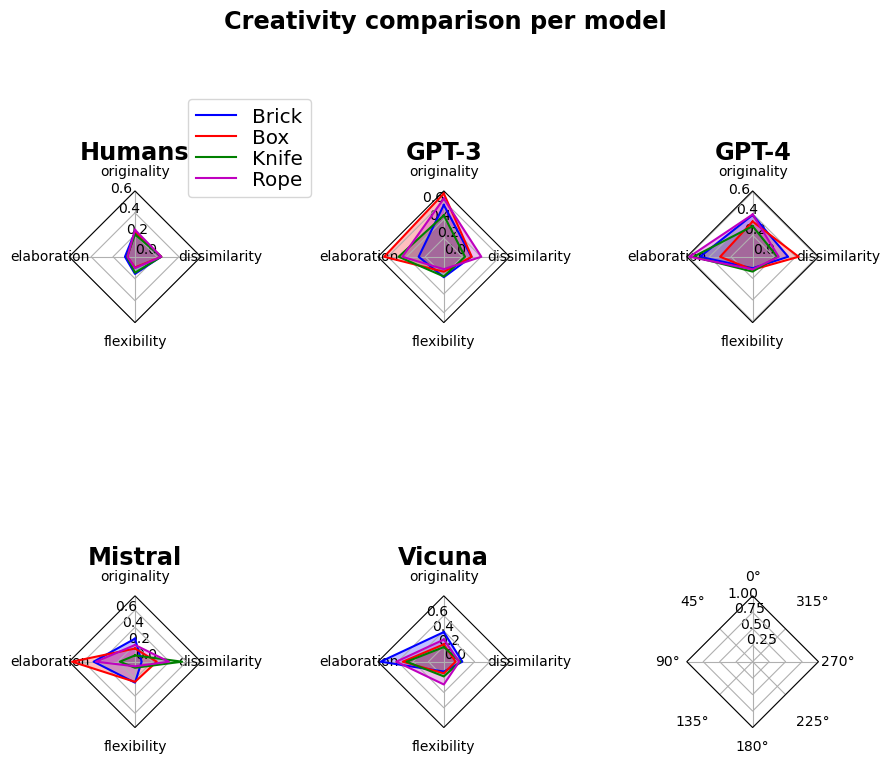

In [23]:
# dimensions to plot
#features_to_plot = ["originality", "elaboration", "elaboration_SW", "dissimilarity"]
features_to_plot = ["originality", "elaboration", "flexibility", "dissimilarity"]

radar_charts_per_model(humans_norm_per_model, gpt_35_norm_per_model, gpt_4_norm_per_model, mistral_norm_per_model, vicuna_norm_per_model, features_to_plot)

## Other plots

### Univariate analysis

In [24]:
def plot_per_object(type, data_dict, features, combined_data_norm_per_object):
    if type == "kde":
        for feat in features:
            fig, axs = plt.subplots(1, 4, figsize=(15, 5))
            for name, df in data_dict.items():
                for i, object in enumerate(['brick', 'box', 'knife','rope']):
                    sns.kdeplot(df[feat], label=name, ax = axs[i])
                    axs[i].set_title(object)
                    axs[i].legend()
        plt.suptitle(f"Comparison on {feat}")
        plt.tight_layout()
        plt.show()
    elif type == "boxplot":
        for feat in features:
            plt.figure(figsize=(12, 5))
            sns.boxplot(data=combined_data_norm_per_object, x='dataset', y=feat, hue = 'prompt')
            plt.suptitle(f"Comparison on {feat}")
            plt.tight_layout()
            plt.show()
    elif type == "violinplot":
        for feat in features:
            plt.figure(figsize=(12, 5))
            sns.violinplot(data=combined_data_norm_per_object, x='dataset', y=feat, hue = 'prompt')
            plt.suptitle(f"Comparison on {feat}")
            plt.tight_layout()
            plt.show()
    else:
        print("Wrong type of plot")
        return 0

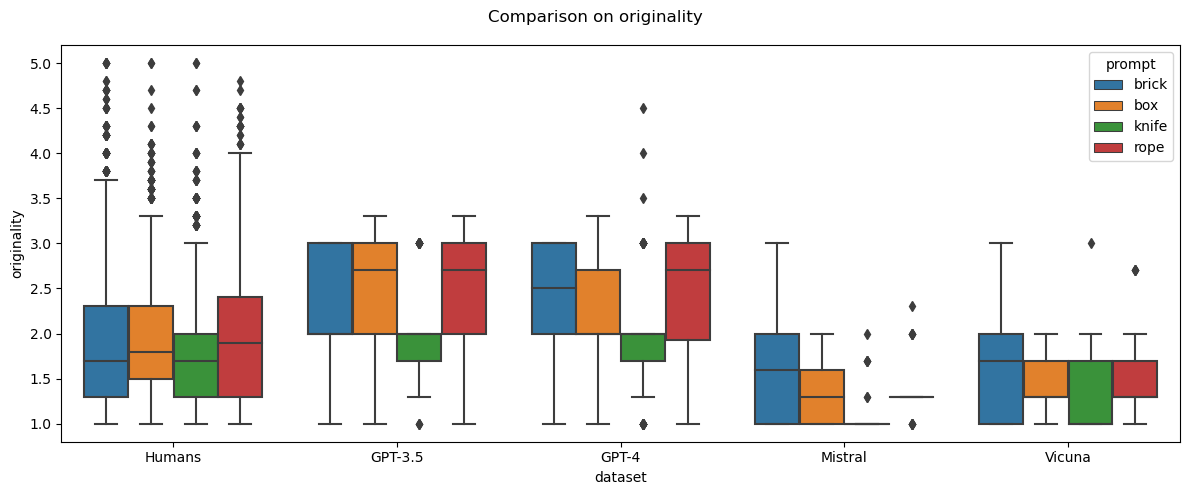

In [27]:
data_dict = {"humans": humans, "gpt_35": gpt_35_processed, "gpt_4": gpt_4_processed, "mistral": mistral_processed, "vicuna": vicuna_processed}

plot_per_object(type = "boxplot", data_dict = data_dict, features = ["originality"], combined_data_norm_per_object = combined_data)

### Multi-variate analysis

**kdeplots between 2 features**

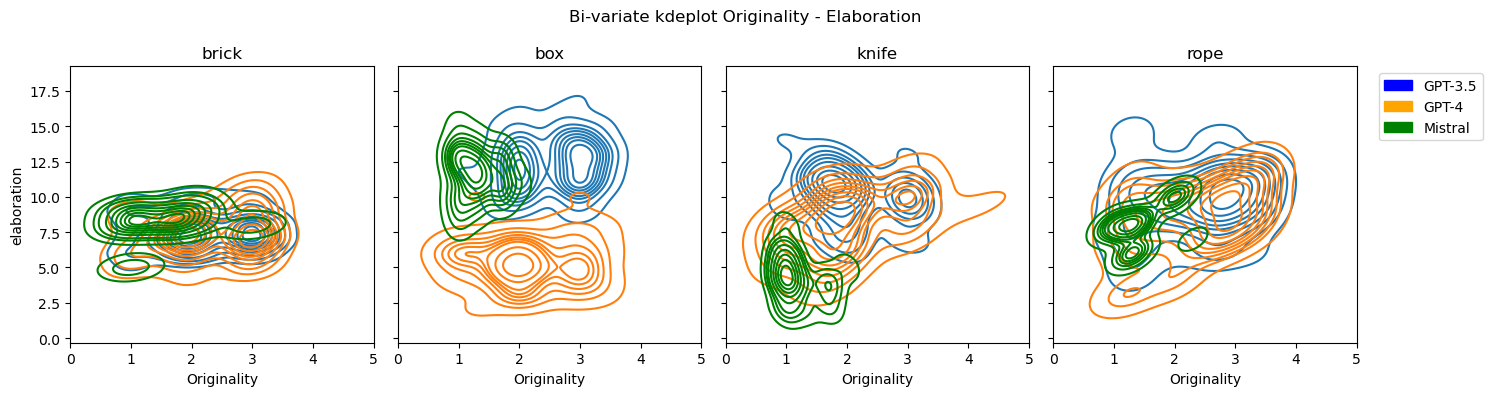

In [28]:
import matplotlib.patches as mpatches

# relation between originality and elaboration
fig, axs = plt.subplots(1,4, figsize=(15, 4), sharey=True)

    # Define custom legend handles
legend_handles = [
    mpatches.Patch(color='blue', label='GPT-3.5'),
    mpatches.Patch(color='orange', label='GPT-4'),
    mpatches.Patch(color='green', label='Mistral')
]

objects = ['brick', 'box', 'knife', 'rope']
for i, object_name in enumerate(objects):

    object_gpt_35 = gpt_35_processed[gpt_35_processed['prompt'] == object_name]
    object_gpt_4 = gpt_4_processed[gpt_4_processed['prompt'] == object_name]
    object_mistral = mistral_processed[mistral_processed['prompt'] == object_name]
    
    #sns.kdeplot(x = object_ground_truth['target'], y = object_ground_truth['elaboration'], label=f'Humans, N = {len(object_ground_truth)}', ax = axs[i])
    sns.kdeplot(x = object_gpt_35['originality'], y = object_gpt_35['elaboration'], label='GPT-3.5', ax = axs[i])
    sns.kdeplot(x = object_gpt_4['originality'], y = object_gpt_4['elaboration'], label='GPT-4', ax = axs[i])
    sns.kdeplot(x = object_mistral['originality'], y = object_mistral['elaboration'], label='Mistral', ax = axs[i],color = 'green')
    
    axs[i].set_title(f'{object_name}')
    axs[i].set_xlabel('Originality')
    axs[i].set_xlim([0,5])
    
#plt.legend(loc='upper right', bbox_to_anchor=(1.6, 1.0))
# Add custom legend with specified handles
plt.legend(handles=legend_handles, loc='upper left', bbox_to_anchor=(1.05, 1.0))
plt.suptitle(f'Bi-variate kdeplot Originality - Elaboration')
plt.tight_layout()
plt.show()

###

**Correlation between dimensions**

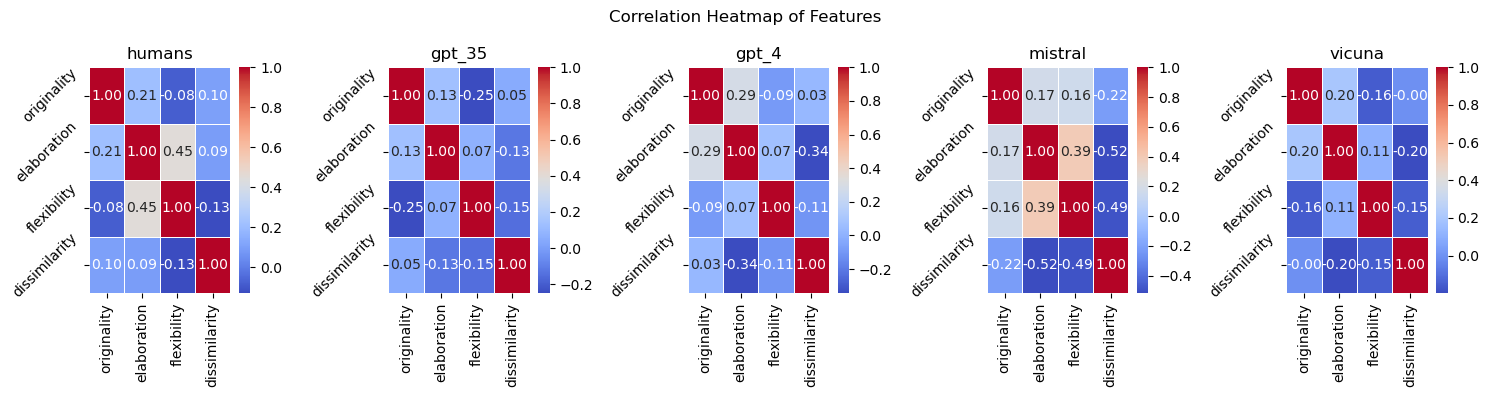

In [148]:
data_dict = {"humans": humans, "gpt_35": gpt_35_processed, "gpt_4": gpt_4_processed, "mistral": mistral_processed, "vicuna": vicuna_processed}

features = ['originality', 'elaboration', 'flexibility', 'dissimilarity']
fig, axs = plt.subplots(1, len(data_dict), figsize=(15, 4))
i = 0
for name, df in data_dict.items():
    corr_matrix = df[features].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, ax = axs[i])
    axs[i].set_title(name)
    axs[i].tick_params(axis = 'y', rotation = 45)
    i += 1
plt.suptitle('Correlation Heatmap of Features')
plt.tight_layout()
plt.show()

---

# ANALYSIS

Organization:
- POS Tagging
- Topic Modeling (Flexibility)

### POS tagging

In [16]:
df_pos = compute_pos_tagging(combined_data)

100%|██████████| 94/94 [00:00<00:00, 1545.04it/s]


POS tagging: [ 4.83286299 11.54798762  9.68055556  8.36666667  6.23404255]
Ground truth: [4.699044151115157, 10.526315789473685, 8.636111111111111, 8.0, 6.23404255319149]


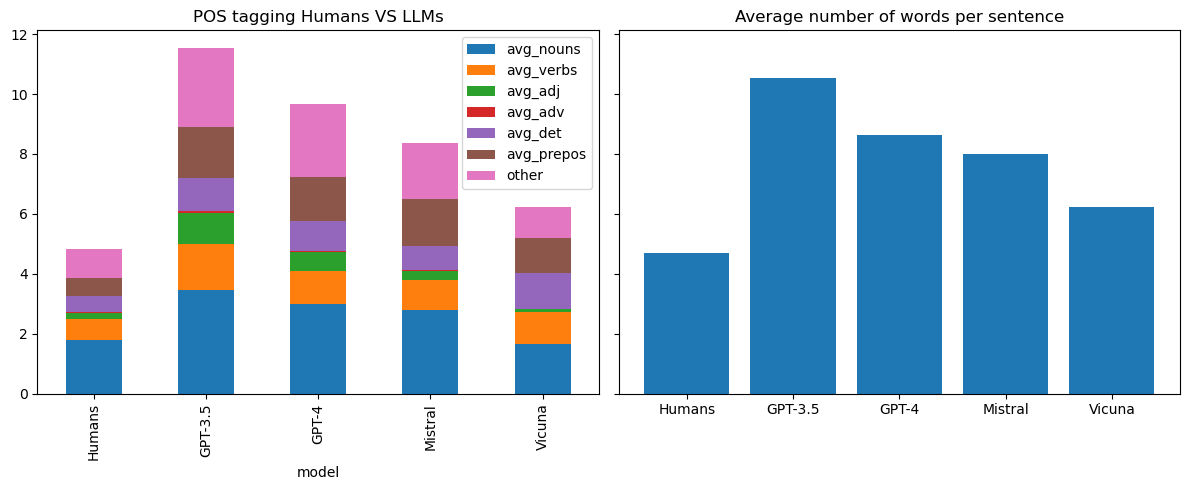

In [17]:
plot_POS(combined_data, df_pos)

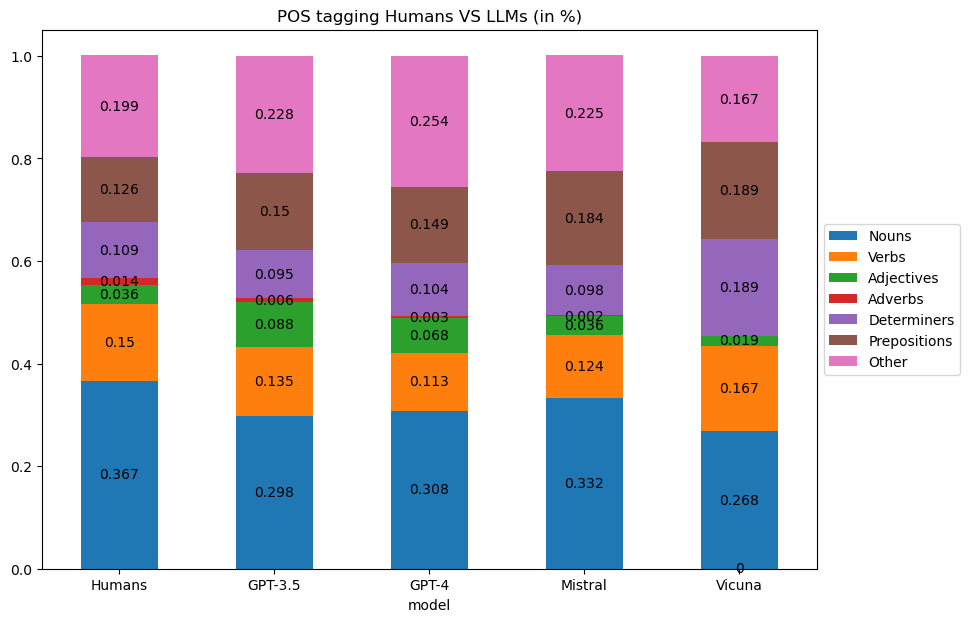

In [18]:
plot_POS_proportions(df_pos)

### Topic modeling

In [43]:
#sns.histplot(data = humans_topic, x = 'prompt', hue = 'topic', hue_order = np.arange(num_topics).tolist(), multiple = 'stack')#, stat = 'probability', common_norm = False)
#plt.show()

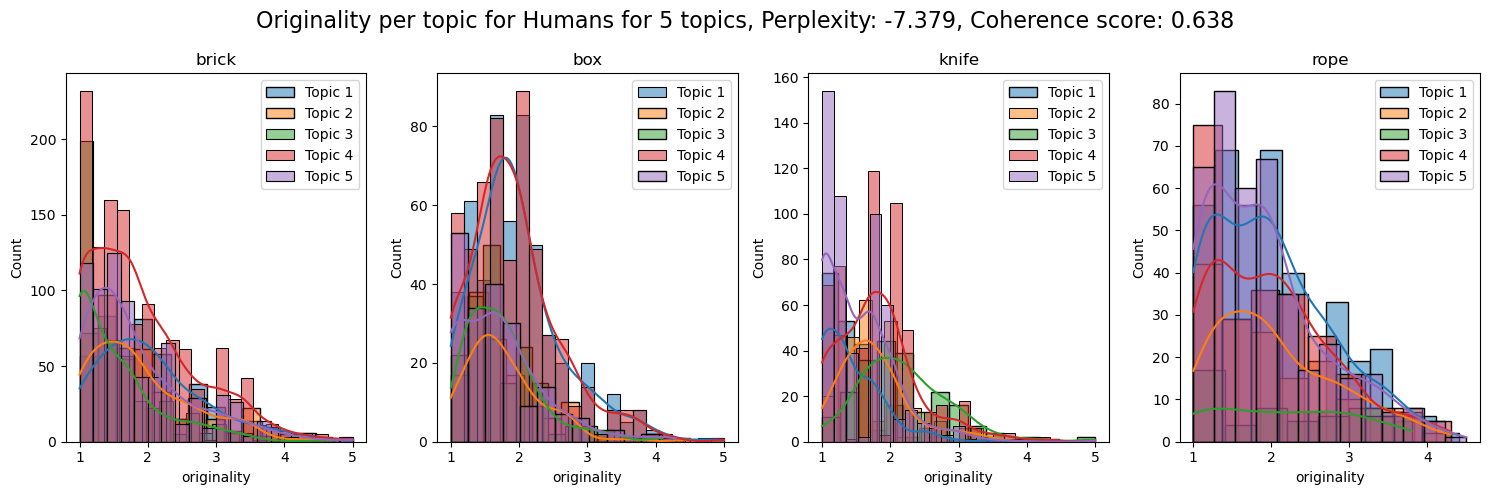

In [ ]:
#plot_originality_per_topic(humans, lda_model_list, 'Humans', False, num_topics)

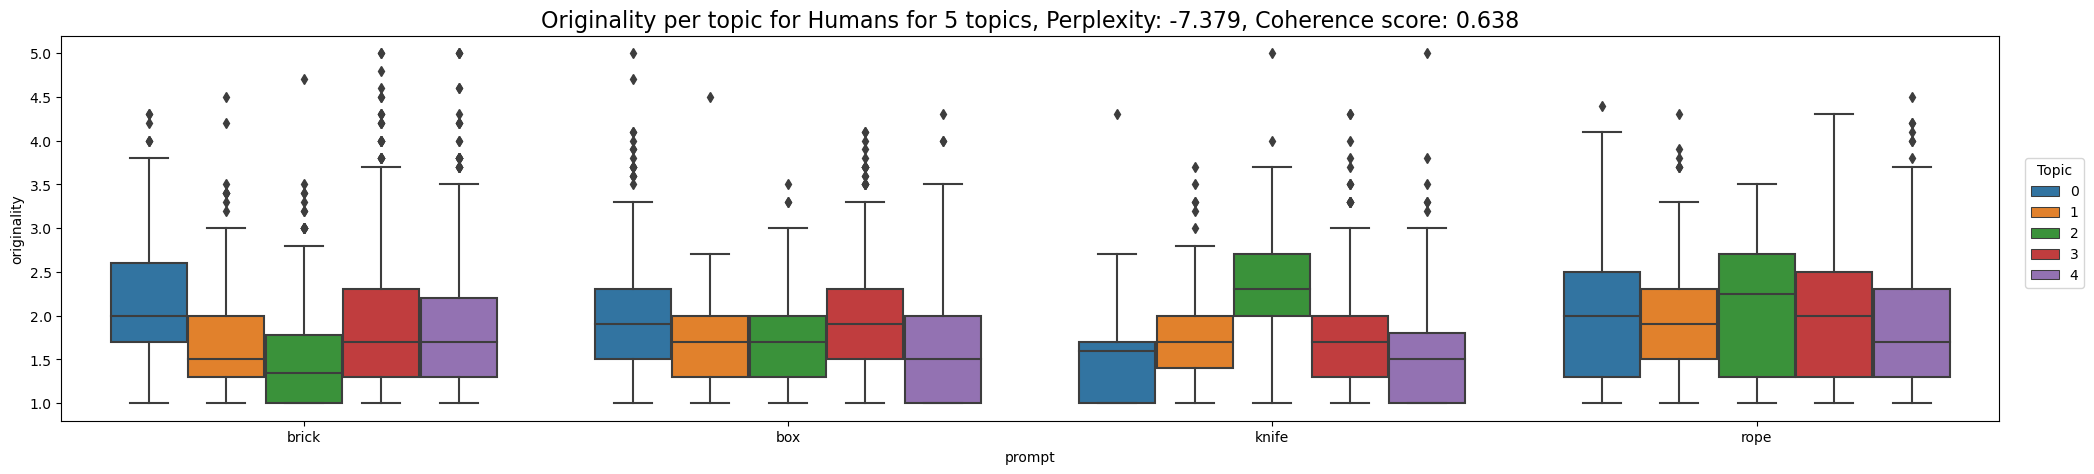

In [78]:
# boxplots
plt.figure(figsize=(25, 5))
sns.boxplot(data=humans_topic, x='prompt', y='originality', hue = 'topic', hue_order = np.arange(num_topics).tolist())
#plt.title("Originality per topic")
plt.title(f"Originality per topic for Humans for {num_topics} topics, Perplexity: {np.array(perplexity).mean().round(3)}, Coherence score: {np.array(coherence_score).mean().round(3)}", fontsize = 16)

plt.legend(title = 'Topic', bbox_to_anchor=(1.01, 0.7), loc='upper left')
plt.show()

### Topics overlap in dataset

In [26]:
# Function to calculate Jaccard similarity between two lists
def jaccard_similarity(list1, list2):
    set1 = set(list1)
    set2 = set(list2)
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union != 0 else 0

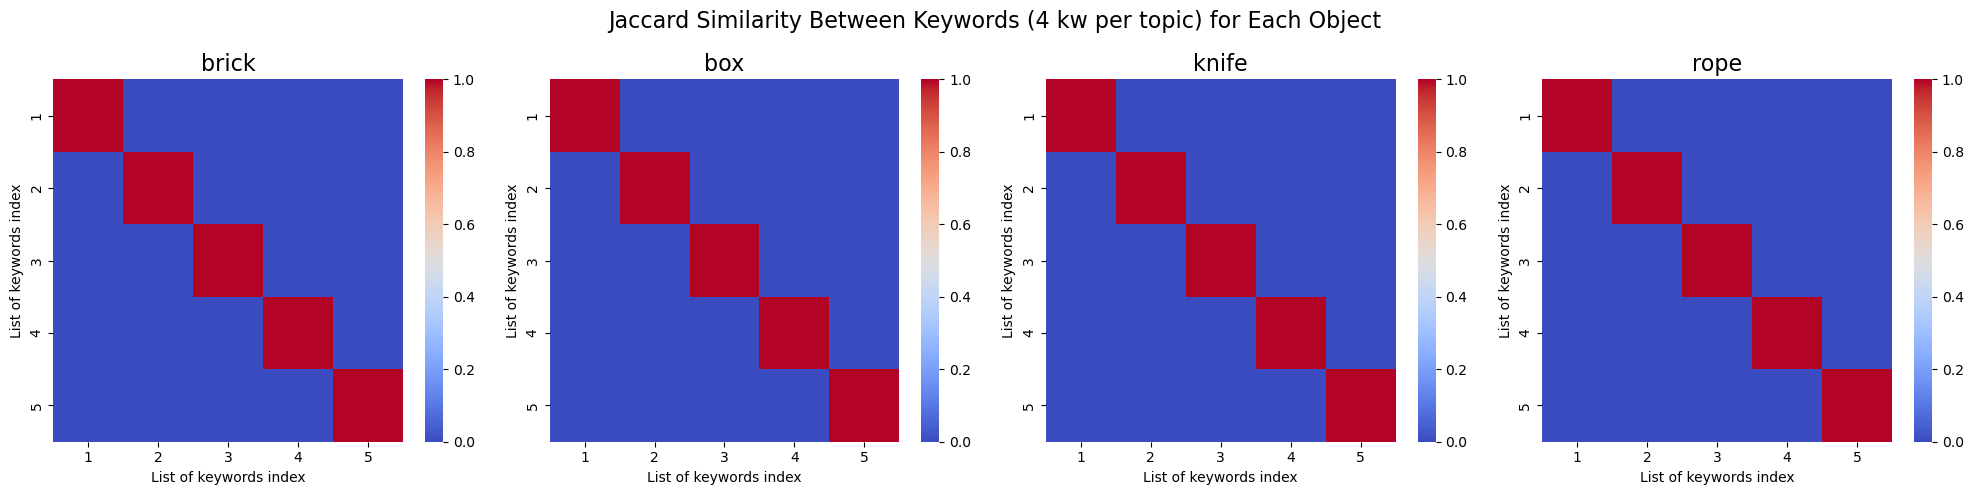

In [27]:
fig, axs = plt.subplots(1, 4, figsize = (20,5))
for idx, object in enumerate(objects):
    
    keyword_lists = df_kw_per_topic[df_kw_per_topic['object'] == object]['keywords'].tolist()
    
    # Calculate Jaccard similarity matrix
    num_lists = len(keyword_lists)
    similarity_matrix = np.zeros((num_lists, num_lists))
    for i in range(num_lists):
        for j in range(i, num_lists):
            similarity_matrix[i, j] = jaccard_similarity(keyword_lists[i], keyword_lists[j])
            similarity_matrix[j, i] = similarity_matrix[i, j]  # Symmetric matrix
    # Plot heatmap
    sns.heatmap(similarity_matrix, annot=False, cmap='coolwarm', fmt='.2f', xticklabels=range(1, num_lists + 1), yticklabels=range(1, num_lists + 1), ax = axs[idx])
    axs[idx].set_xlabel('List of keywords index')
    axs[idx].set_ylabel('List of keywords index')
    axs[idx].set_title(object, fontsize = 16)
plt.suptitle(f"Jaccard Similarity Between Keywords ({num_words} kw per topic) for Each Object", fontsize = 16)
plt.tight_layout()
plt.show()

### Evaluate topic modeling

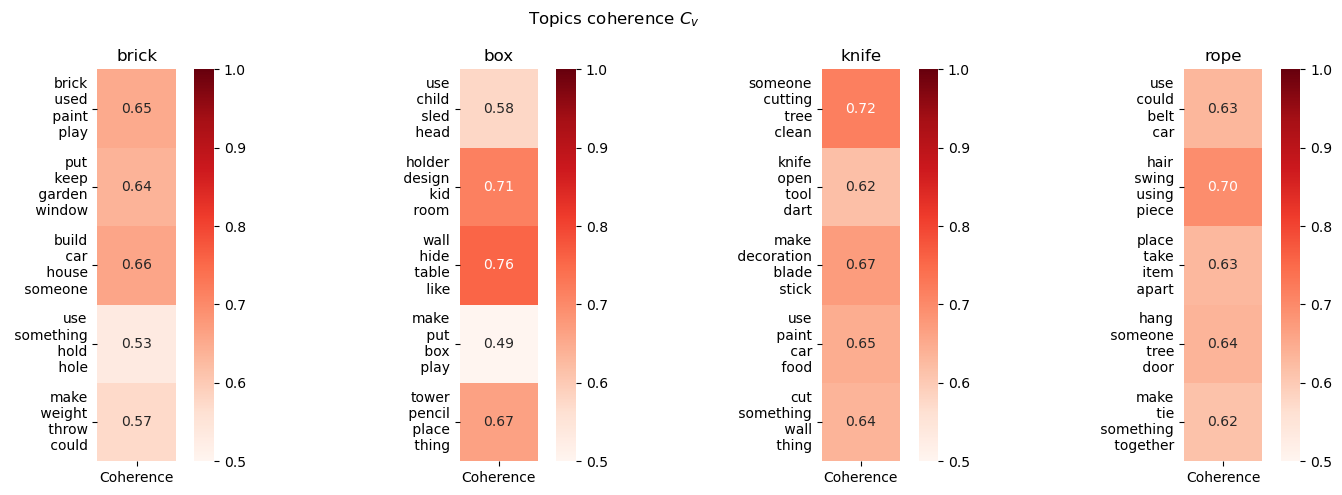

In [29]:
fig, axs = plt.subplots(1, 4, figsize=(15, 5))
for idx, object in enumerate(objects):
    topics = df_kw_per_topic[df_kw_per_topic['object'] == object]['keywords'].tolist()
    coherence_per_topic = df_kw_per_topic[df_kw_per_topic['object'] == object]['coherence_score'].tolist()

    topics_str = [ '\n '.join(t) for t in topics ]
    data_topic_score = pd.DataFrame( data=zip(topics_str, coherence_per_topic), columns=['Topic', 'Coherence'] )
    data_topic_score = data_topic_score.set_index('Topic')

    sns.heatmap(data=data_topic_score, annot=True, square=True,
                cmap='Reds', fmt='.2f',
                linecolor='black', ax=axs[idx], vmin=0.5, vmax=1)
    axs[idx].tick_params(axis = 'y', rotation = 0)
    axs[idx].set_xlabel('')
    axs[idx].set_ylabel('')
    axs[idx].set_title(object)
plt.suptitle("Topics coherence $C_v$")
plt.tight_layout()
plt.show()

### Choose the best number of topics

**Plot** coherence with respect to the number of topics

In [275]:
# takes 9-10 min to run
cm_topic = pd.DataFrame(columns = ['object', 'num_topic', 'coherence_score'])
num_topics = 16
num_words = 5

for N in range(2, num_topics):
    lda_model_brick = create_lda_model(humans, 'brick', num_topics=N)
    lda_model_box = create_lda_model(humans, 'box', num_topics=N)
    lda_model_knife = create_lda_model(humans, 'knife', num_topics=N)
    lda_model_rope = create_lda_model(humans, 'rope', num_topics=N)

    lda_model_list = [lda_model_brick, lda_model_box, lda_model_knife, lda_model_rope]

    humans_topic,  df_kw_per_topic, perplexity, coherence_score, coherence_score_per_topic = assign_topic_all(humans, lda_model_list, print_keywords = False, num_topics = N, num_words = num_words)
    for j, object in enumerate(objects):
        cm_topic.loc[len(cm_topic)] = [object, N, coherence_score[j]]
cm_topic.head()

Number of documents in corpus for object "brick": 4056


Number of documents in corpus for object "box": 2703
Number of documents in corpus for object "knife": 2178
Number of documents in corpus for object "rope": 2048
Number of documents in corpus for object "brick": 4056
Number of documents in corpus for object "box": 2703
Number of documents in corpus for object "knife": 2178
Number of documents in corpus for object "rope": 2048
Number of documents in corpus for object "brick": 4056
Number of documents in corpus for object "box": 2703
Number of documents in corpus for object "knife": 2178
Number of documents in corpus for object "rope": 2048
Number of documents in corpus for object "brick": 4056
Number of documents in corpus for object "box": 2703
Number of documents in corpus for object "knife": 2178
Number of documents in corpus for object "rope": 2048
Number of documents in corpus for object "brick": 4056
Number of documents in corpus for object "box": 2703
Number of documents in corpus for object "knife": 2178
Number of documents in c

,object,num_topic,coherence_score
0,brick,2,0.408381
1,box,2,0.500564
2,knife,2,0.623351
3,rope,2,0.550544
4,brick,3,0.520319


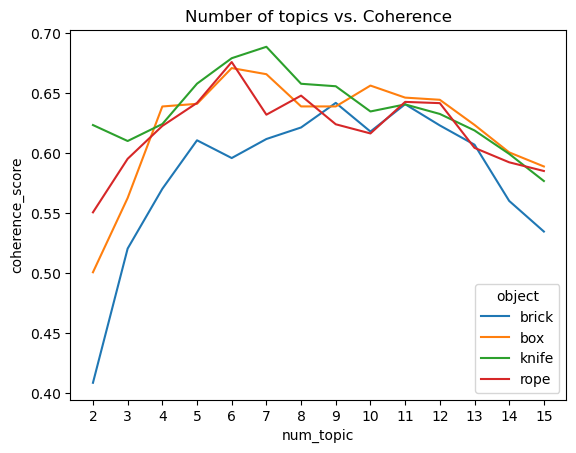

In [276]:
# plot
sns.lineplot(data = cm_topic, x = 'num_topic', y = 'coherence_score', hue = 'object')
# only integers on x axis 
plt.xticks(np.arange(2, num_topics, 1))
plt.title("Number of topics vs. Coherence")
plt.show()

### Comparison 

- Humans annotation vs. OCSAI vs. OCSTB for Humans
- OCSAI vs. OCSTB for LLMs

In [39]:
model = humans

df_topic_score = compute_originality_topic(model, dict_kw_coeff, num_topics, objects)
print("Length dataframe:", len(df_topic_score))
df_topic_score.head()

Length dataframe: 10985


,prompt,response,originality,elaboration,cosine_dist,elaboration_SW,flexibility
4,brick,strength tester (punching),2.7,3,0.294817,5,0.000000
5,brick,art,2.1,1,0.330149,1,0.000000
11,brick,pencil holder,2.1,2,0.246490,2,1.717956
12,brick,writing utensil,2.1,2,0.232353,2,0.000000
14,brick,earrings,2.2,1,0.275411,1,0.000000


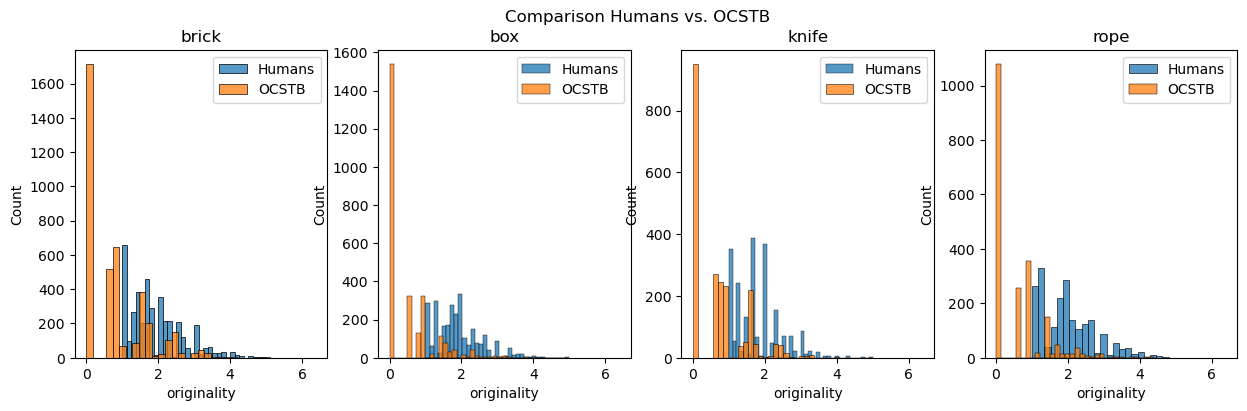

In [36]:
# compare originality from OCSAI and OCSTB = Open Creativity Scoring Topic Based

fig, axs = plt.subplots(1, 4, figsize = (15,4), sharex = True)
for i, object in enumerate(objects):
    sns.histplot(data = df_topic_score[df_topic_score['prompt'] == object], x = 'originality', label = "Humans", ax = axs[i])
    sns.histplot(data = df_topic_score[df_topic_score['prompt'] == object], x = 'originality_topic', label = "OCSTB", ax = axs[i])
    axs[i].set_title(object)
    axs[i].legend()
plt.suptitle("Comparison Humans vs. OCSTB")
plt.show()

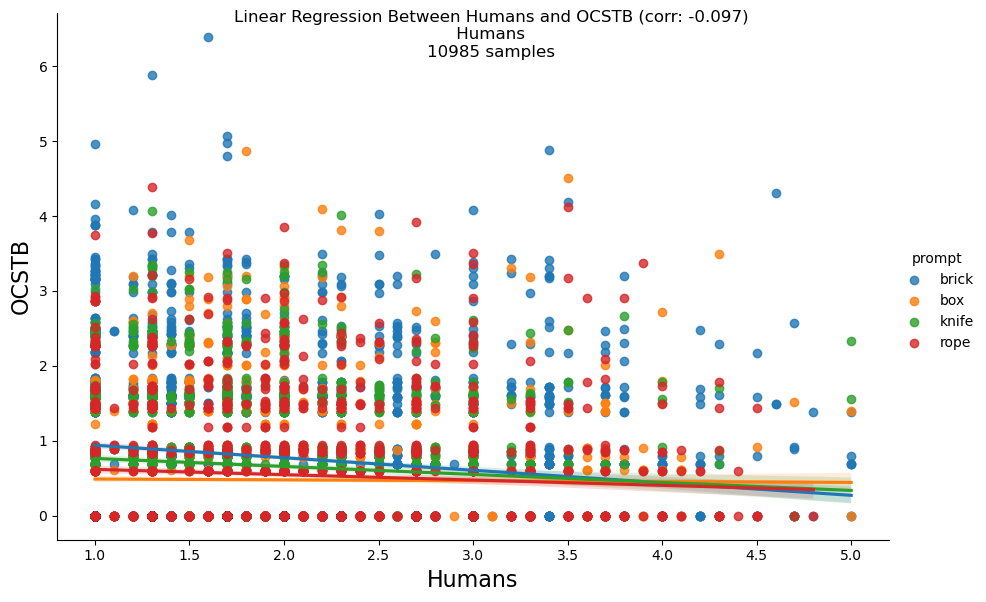

In [37]:
# Compute correlation
correlation = df_topic_score['originality'].corr(df_topic_score['originality_topic'])

# Plot linear regression line
#fig, axs = plt.subplots(1, 2, figsize = (15,6))
#sns.lmplot(data=df_topic_score, x='originality', y='originality_topic', col = 'prompt', height=6, aspect=1.5)
sns.lmplot(x='originality', y='originality_topic', data=df_topic_score, hue = 'prompt', height=6, aspect=1.5)
#sns.lmplot(x='originality', y='originality_topic', data=df_topic_score, height=6, aspect=1.5)
plt.suptitle(f'Linear Regression Between Humans and OCSTB (corr: {correlation.round(3)})\n Humans \n{len(df_topic_score)} samples')
plt.xlabel('Humans', fontsize = 16)
plt.ylabel('OCSTB', fontsize = 16)
plt.show()

In [101]:
humans.head()

,prompt,response,originality,elaboration,cosine_dist,elaboration_SW
0,rope,use it to tie up a bicycle,1.9,7,0.238301,3
1,rope,steps,1.3,1,0.277273,1
2,rope,dog toy,1.4,2,0.257513,2
3,box,use it to reach something,1.7,5,0.273910,3
4,brick,strength tester (punching),2.7,3,0.294817,5


In [107]:
# run on server

#humans_ocsai = humans.copy()
#
#for i in tqdm(range(len(humans_ocsai))):
#    eval_ocsai = call_api_ocsai(humans_ocsai.loc[i, 'prompt'], humans_ocsai.loc[i, 'response'])
#    humans_ocsai.loc[i, 'originality_ocsai'] = eval_ocsai['scores'][0]['originality']  # see if we can speed up eval if we pass batches of sentences
#    humans_ocsai.loc[i, 'elaboration_ocsai'] = eval_ocsai['scores'][0]['elaboration']
#humans_ocsai.head()

0.4332515384262847


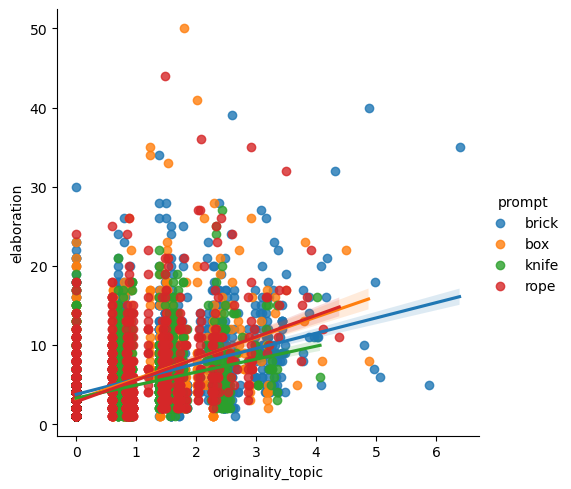

In [129]:
print(df_topic_score['originality_topic'].corr(df_topic_score['elaboration']))
sns.lmplot(x='originality_topic', y='elaboration', data=df_topic_score, hue = 'prompt')

### Visualize topic modeling with pyLDAvis

In [184]:
#visu_with_pyldavis(lda_model_brick, humans, object = 'brick')